# Semi-Supervised Learning
**Aprendizaje Automático Avanzado (AAA)**

_Alan García Justel_

En este _notebook_ se pretende explorar técnicas de aprendizaje automático avanzado. Para ello, se van a utilizar los datos del dataset Iris y se van a probar los algoritmos de _Self-training_ y _Expectation Maximization (EM)_. Algunas notas sobre el _Semi-Supervised Learning_:

- **Web:** _<<Semi-supervised learning is a broad category of machine learning that uses labeled data to ground predictions, and unlabeled data to learn the shape of the larger data distribution>>_

- **GPT-4o mini:** _<<El aprendizaje automático semisupervisado combina datos etiquetados y no etiquetados para entrenar modelos, aprovechando una pequeña cantidad de información supervisada junto con la estructura de los datos sin etiquetar>>_

- **ScikitLearn SelfTrainingClassifier:** _<<The self-training classifier class allows a given supervised classifier to function as a semi-supervised classifier, allowing it to learn from unlabeled data. It does this by iteratively predicting pseudo-labels for the unlabeled data and adding them to the training set. The classifier will continue iterating until either max_iter is reached, or no pseudo-labels were added to the training set in the previous iteration>>_

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

## Análisis del Dataset

> El dataset de Iris contiene 4 atributos ("Ancho del sépalo", "Alto del sépalo", "Ancho del pétalo" y "Alto del pétalo") más la clasificación de la flor. Sin embargo, para facilitar la representación, sólo se van a utilizar el ancho y alto del sépalo.

In [2]:
### FUNCIONES DE AYUDA #####################################################################
def load_iris_dataset(normalize = True) -> tuple:
    iris = datasets.load_iris(as_frame=True)
    X = iris.data
    Y = iris.target

    print(f"[IRIS Dataset]  feature names: {iris.feature_names}, targets: {np.unique(Y)}. target names: {iris.target_names}")

    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    return X, Y

# Label namemap
label2name = {
    -1: "Unlabeled", 0:  "Setosa", 1:  "Versicolor", 2:  "Virginica"
}

# Label colormap
label2color = {
    -1: (229, 0, 106),  # unlabeled color
    0:  (162, 78, 255), # setosa color
    1:  (0, 235, 111),  # versicolor color
    2:  (0, 122, 210)   # virginica color
}
label2color = {key: tuple(value / 255 for value in rgb) for key, rgb in label2color.items()}

# Extraer los datos de una única clase
def extract_one_class(X: np.ndarray, Y: np.ndarray, label: int) -> tuple:
    mask = Y == label
    return X[mask], Y[mask]

In [3]:
# Cargar el Dataset
X, Y = load_iris_dataset()

[IRIS Dataset]  feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], targets: [0 1 2]. target names: ['setosa' 'versicolor' 'virginica']


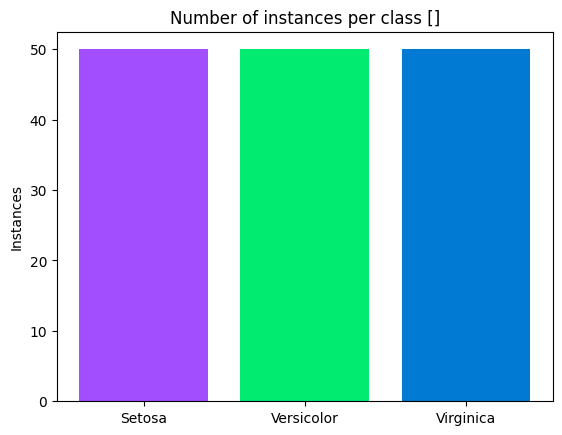

In [4]:
def plot_number_of_instances_per_class(Y:np.ndarray, sum_labeled_blocks = False, title_label = ""):
        counts = []
        labels = []
        colors = []
        for l in sorted(np.unique(Y)):
                counts.append(np.sum(Y == l))
                labels.append(label2name[l])
                colors.append(label2color[l])
        #print(f"counts: {counts}, labels: {labels}")

        plt.title(f"Number of instances per class [{title_label}]")
        if sum_labeled_blocks:
                bottom = 0.0
                for ct, l, col in zip(counts, labels, colors):
                        bar_index = int(l != "Unlabeled")
                        plt.bar(bar_index, ct, color=col, label=l, bottom=bottom)
                        if bar_index:
                                bottom += ct
                plt.legend()
        else:
                plt.bar(labels, counts, color = colors)
        plt.ylabel('Instances')
        plt.show()

plot_number_of_instances_per_class(Y)

Todas las clases están balanceadas, luego vamos tomar todos los conjuntos y elegir de forma aleatoria las instancias que pierden la clase

In [5]:
def get_set_with_unlabeled_items(Y: np.ndarray, unlabeled_prob: float = 0.3):
    """
    INPUT: 
    - Y conjunto de labels
    - unlabeled_prob: probabilidad de que una instancia pierda la etiqueta
    OUTPUT: conjunto Y donde algunas instancias han perdido la etiqueta (target = -1)
    """
    Y_unlabeled = Y.copy()
    y_rand_mask = np.random.rand(Y_unlabeled.shape[0])
    
     # set random samples to be unlabeled
    Y_unlabeled[y_rand_mask < unlabeled_prob] = -1 
    return Y_unlabeled

# Ejemplo de uso
Y_30 = get_set_with_unlabeled_items(Y, unlabeled_prob= 0.3)
Y_30

0      0
1      0
2      0
3     -1
4     -1
      ..
145    2
146    2
147    2
148   -1
149    2
Name: target, Length: 150, dtype: int64

## Data Preparation

unlabeled_prob: 0.4, train_labeled_size: 0.8
Numero de instancias por label del train: [{'Unlabeled': 66}, {'Setosa': 21}, {'Versicolor': 20}, {'Virginica': 26}]
Numero de instancias por label del test: [{'Setosa': 4}, {'Versicolor': 10}, {'Virginica': 3}]



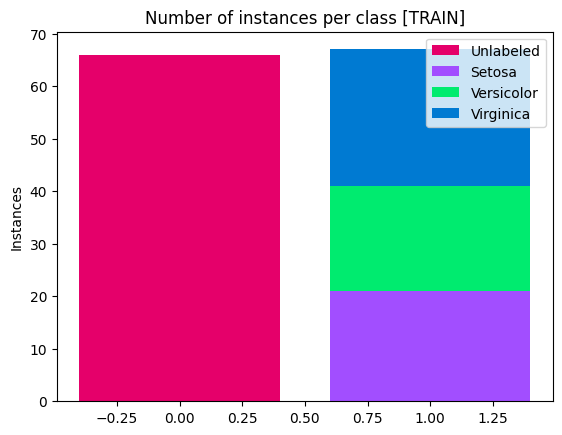

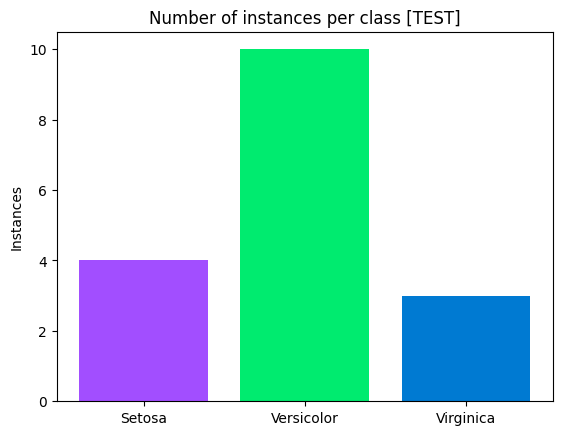

In [6]:
# Generar conjuntos de train y test. Para el conjunto de test se tienen que apartar unas pocas instancias clasificadas

def create_train_test(X, Y, unlabeled_prob: float, train_labeled_size: float =  0.8, verbose = False):
    """
    Primero se quitan las etiquetas de las instancias con la probabilidad `unlabeled_prob` y luego
    se crean los conjuntos de train y test donde train tiene tantas instancias etiquetadas
    como  `train_labeled_size` junto con todas las instancias sin etiqueta generadas
    INPUT: 
    - X: Conjunto de datos
    - Y: Conjunto de etiquetas
    - unlabeled_prob: Probabilidad de que una instancia pierda la etiqueta
    - train_labeled_size: Tamaño del conjunto de datos etiquetados que irán al train
    OUTPUT: `X_train`, `X_test`, `Y_train`, `Y_test`
    """
    
    U = get_set_with_unlabeled_items(Y, unlabeled_prob=unlabeled_prob)

    # X[Y_30 != -1]     -> Aquellas instancias que siguen conservando la etiqueta
    # Y_30[Y_30 != -1]  -> Los labels de las instancias que conservan las etiquetas
    if len(U != -1) == 0:
        raise Exception(f"Con unlabeled_prob = {unlabeled_prob} se ha generado un dataset en el que no existe ninguna instancia clasificada.")
    
    X_train_labeled, X_test, Y_train_labeled, Y_test = train_test_split(X[U != -1], U[U != -1], train_size=train_labeled_size)

    # Generar el conjunto de entrenamiento final -> Instancias Etiquetadas + Sin Etiqueta
    X_train = np.vstack(( X_train_labeled, X[U == -1] )) 
    Y_train = np.hstack(( Y_train_labeled, U[U == -1] )) 

    # Calcular el número de instancias con label de cada conjunto
    num_instances_train = [ {label2name[l]: int(np.sum(Y_train == l))} for l in np.unique(Y_train)]
    num_instances_test  = [ {label2name[l]: int(np.sum(Y_test == l))} for l in np.unique(Y_test)]

    if verbose:
        print(f"unlabeled_prob: {unlabeled_prob}, train_labeled_size: {train_labeled_size}")
        print(f"Numero de instancias por label del train: {num_instances_train}")
        print(f"Numero de instancias por label del test: {num_instances_test}")
        print()
    return X_train, X_test, Y_train, Y_test

# Ejemplo de uso
X_train, X_test, Y_train, Y_test = create_train_test(X, Y, unlabeled_prob= 0.4, train_labeled_size=0.8, verbose=True)
plot_number_of_instances_per_class(Y_train, sum_labeled_blocks = True, title_label="TRAIN")
plot_number_of_instances_per_class(Y_test, title_label="TEST")

## Self-Training

Para aplicar _Self-Training_ sobre los datos de _iris_ se va a utilizar un clasificador base _Naive Bayes_ y la implementación de _Self-Training_ proporcionada por _Scikit-Learn_.

En este experimento se pretende graficar el comportamiento o la mejora que se obtiene al utilizar ´Self-Training´ respecto a un clasificador entrenado únicamente con datos etiquetados. Por ello, se van a realizar varias iteraciones en las que el número de instancias sin etiquetas va aumentando hasta que se aproxima a 1 (pero no llega, ya que entrenenar un clasificador solo con datos sin etiquetar sería un problema de _One-Class Classification_). Además, por cada fracción de datos sin etiquetar se va a realizar el proceso de partición y entrenamiento varias veces.

In [7]:
base_classifier = GaussianNB()
st30 = SelfTrainingClassifier(base_classifier).fit(X_train, Y_train)
y_pred = st30.predict(X_test)
acc = accuracy_score(y_pred, Y_test)
acc

0.7647058823529411

repeats: 10, fractions: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


/workspaces/KISA/.venv/lib/python3.12/site-packages/sklearn/semi_supervised/_self_training.py:227: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/workspaces/KISA/.venv/lib/python3.12/site-packages/sklearn/semi_supervised/_self_training.py:227: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/workspaces/KISA/.venv/lib/python3.12/site-packages/sklearn/semi_supervised/_self_training.py:227: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/workspaces/KISA/.venv/lib/python3.12/site-packages/sklearn/semi_supervised/_self_training.py:227: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/workspaces/KISA/.venv/lib/python3.12/site-packages/sklearn/semi_supervised/_self_training.py:227: UserWarning: y contains no unlabeled samples
  warnings.warn("y conta

Text(0.5, 0, 'Remove Label Probability')

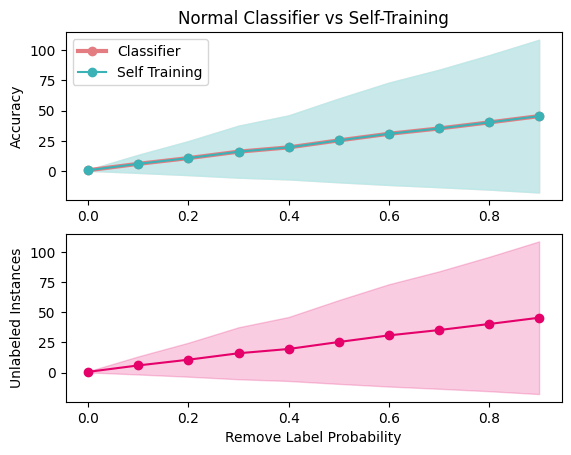

In [8]:
repeats = 10
fractions = np.arange(start=0, stop=1, step=0.1) # Fractions of unlabeled instances
print(f"repeats: {repeats}, fractions: {fractions}")

nb_accs             = {'mean': [], 'std': [] }
st_accs             = {'mean': [], 'std': [] }
num_of_unlabeled    = {'mean': [], 'std': [] }

for i, frac in enumerate(fractions):
    nb_accs_aux = st_accs_aux = num_of_aux = []

    for _ in range(repeats):
        # Crear partición de datos eliminando etiquetas en función de frac
        X_train, X_test, Y_train, Y_test = create_train_test(X, Y, unlabeled_prob= frac, verbose=False)
        num_of_aux.append(np.sum(Y_train == -1))

        # Normal Classifier -> Descartamos las instancias no etiquetadas
        nb = GaussianNB()
        nb.fit(X_train[Y_train != -1], Y_train[Y_train != -1])
        nb_accs_aux.append( accuracy_score( nb.predict(X_test), Y_test) )

        # Self-Training
        st_base_classifier = GaussianNB()
        st = SelfTrainingClassifier(st_base_classifier).fit(X_train, Y_train)
        st_accs_aux.append( accuracy_score(st.predict(X_test), Y_test) )
    
    # Register data
    nb_accs['mean'].append(np.mean(nb_accs_aux)) ; nb_accs['std'].append(np.std(nb_accs_aux))
    st_accs['mean'].append(np.mean(st_accs_aux)) ; st_accs['std'].append(np.std(st_accs_aux))
    num_of_unlabeled['mean'].append(np.mean(num_of_aux)) ; num_of_unlabeled['std'].append(np.std(num_of_aux))


# Convert to numpy array
nb_accs['mean'] = np.array(nb_accs['mean']) ; nb_accs['std'] = np.array(nb_accs['std'])
st_accs['mean'] = np.array(st_accs['mean']) ; st_accs['std'] = np.array(st_accs['std'])
num_of_unlabeled['mean'] = np.array(num_of_unlabeled['mean']); num_of_unlabeled['std'] = np.array(num_of_unlabeled['std'])

# Show
fig, (ax1, ax2) = plt.subplots(2)
ax1.set_title("Normal Classifier vs Self-Training")
ax1.plot(fractions, nb_accs['mean'], marker='o', c = "#e47d82", linewidth=3,  label = "Classifier" )
ax1.fill_between(fractions, nb_accs['mean'] - nb_accs['std'], nb_accs['mean'] + nb_accs['std'], color='#fdd5d3', alpha=0.7)
ax1.plot(fractions, st_accs['mean'], marker='o', c = "#3bb2b5", label = "Self Training" )
ax1.fill_between(fractions, st_accs['mean'] - st_accs['std'], st_accs['mean'] + st_accs['std'], color='#b2eced', alpha=0.7)
ax1.set_ylabel("Accuracy")
ax1.legend()

ax2.plot(fractions, num_of_unlabeled['mean'], marker='o', c = label2color[-1], label = "Self Training" )
ax2.fill_between(fractions, num_of_unlabeled['mean'] - num_of_unlabeled['std'], num_of_unlabeled['mean'] + num_of_unlabeled['std'], color=label2color[-1], alpha=0.2)
ax2.set_ylabel("Unlabeled Instances")
ax2.set_xlabel("Remove Label Probability")